In [1]:
import os, sys
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from tqdm import tqdm

# TODO: fill in the path to downloaded qick repo".
qick_path = ''
sys.path.append(qick_path)


from qick import *
import time 

# TODO: fill in the path to bitstream files. The bitstream files are in "bitstream files.zip".
bitfile_path = ''

soc = QickSoc(bitfile = bitfile_path)
soccfg = soc
print(soccfg)

Populating the interactive namespace from numpy and matplotlib


resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Software version: 0.2.161
	Firmware timestamp: Tue Aug  1 13:26:58 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelo

In [2]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        
        cfg=self.cfg   

        
        self.declare_gen(# 6
                         ch = cfg["sgMux_ch"], 
                         # 1
                         nqz = cfg['nqz'], 
                         # 950
                         mixer_freq = cfg['mixer_freq'], 
                         # 'freq': [-72.926, -813.588, 819.7247 , 88.406]    
                         mux_freqs = cfg['freq'], 
                         # 'gain': [0.25, 0.95, 0.95, 0.25]
                         mux_gains = cfg['gain'], 
                         # 0
                         ro_ch = 0)


    
        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        


        # will automatically find out mixer freq used by generator (cfg['mixer_freq']) 
            # and add to cfg['freq'][q] inside configure_readout().
        for q in range(len(cfg['freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
        


        self.synci(200)  # give processor some time to configure pulses
    
    
    def body(self):
        
        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        self.pulse(ch=self.cfg['sgMux_ch'])
        
        self.wait_all() 

        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels

  0%|          | 0/100 [00:00<?, ?it/s]

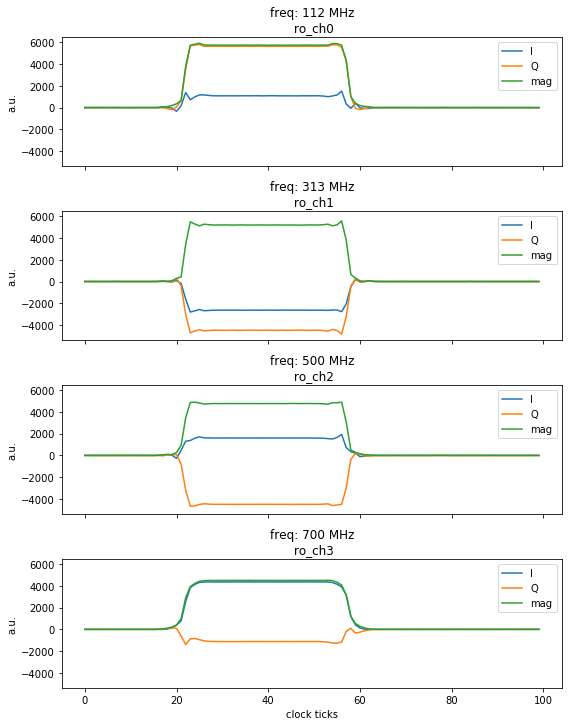

In [14]:
config={
    "sgMux_ch": 6,
    'nqz': 1,
    'mixer_freq': 150,
    'freq': [112, 313, 500, 700],    
    'gain': [0.95, 0.95, 0.95, 0.95],
    "pulse_length": 50,
    
    # Order doesn't matter, and length of cfg['mask'] doesn't need to match that of cfg['freq'].
    # If 0 is present, it means cfg['freq'][0] will be part of the output.
    'mask': [0, 1, 2, 3],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": [100, 100, 100, 100],
    'adc_trig_offset': 90,
    
    "relax_delay": 1.0, 
    "soft_avgs": 100,
    "reps": 1
    
}


prog = LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(8,10))

for i, iq in enumerate(iq_list):    
    axs[i].plot(iq[0], label="I")
    axs[i].plot(iq[1], label="Q")
    axs[i].plot(np.abs(iq[0] + 1j * iq[1]), label="mag")
        
#     axs[i].plot(a, label='proc '+str(i))
    axs[i].legend()
    axs[i].set_ylabel('a.u.')
    axs[i].set_title(f"freq: {config['freq'][i]} MHz\n " + "ro_ch" + str(config['adc_ch'][i]))
    
plt.tight_layout()
# plt.legend()
# plt.xlim([0, 23000])
plt.xlabel('clock ticks')
plt.show()
